<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Необходимый набор библиотек
!pip install matplotlib==3.7.3 numpy==1.22 seaborn==0.11.1 -q
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install phik -q
!pip install python-levenshtein -q

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
import math
from time import time

# Создание pipeline
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузка данных
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()
df.head(10)
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Рассемлирование по одному часу. Данные будут сгруппированы с интервалом в один час.
Зачем рассемплирование:
- Агрегация данных
- Приведение данных к регулярному интервалу
- Снижение шума

In [3]:
df = df.resample('1H').sum()
display(df.head())
display(df.info())
display(df.describe())
print(f"\nМинимальная дата: {df.index.min()}")
print(f"Максимальная дата: {df.index.max()}")


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000



Минимальная дата: 2018-03-01 00:00:00
Максимальная дата: 2018-08-31 23:00:00


## Анализ

Визуализация временного ряда

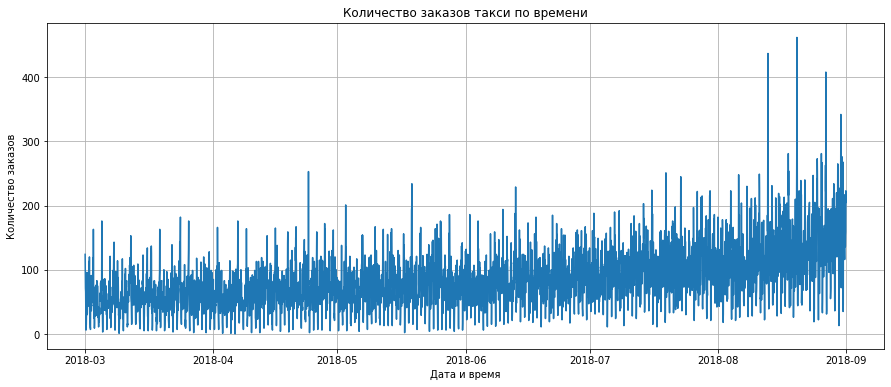

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['num_orders'])
plt.title('Количество заказов такси по времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

Анализ тренда и сезонности

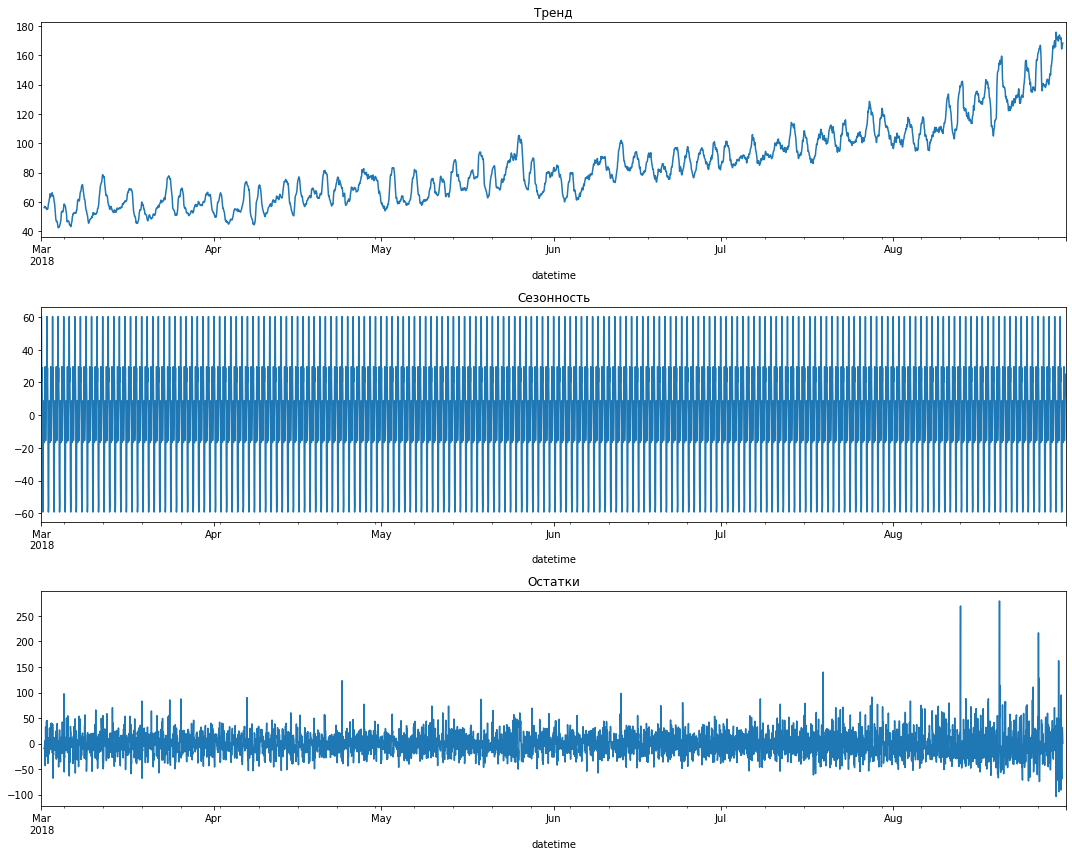

In [5]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()
plt.show()

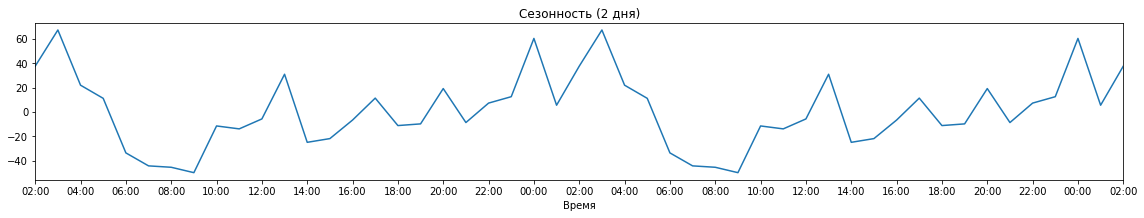

In [6]:
# Выбираем диапазон данных для двух дней
start_date = df.index[0]
end_date = start_date + pd.Timedelta(days=2)
df_week = df[start_date:end_date]

# Декомпозиция данных за 2 дня
decomposed_week = seasonal_decompose(df_week['num_orders'])

# Визуализация
plt.figure(figsize=(16, 8))
plt.subplot(312)
ax = decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность (2 дня)')

# Настройка оси X, метки каждые 2 часа
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))

labels = [f'{i:02d}:00' for i in range(0, 24, 2)] * (df_week.index.max().day-df_week.index.min().day + 1)

ax.set_xticklabels(labels)
plt.xlabel('Время')

plt.tight_layout()
plt.show()

Вывод:
   - Тренд на постепенное увеличение количества заказов.
   - Сезонность внутри дня. С 2.00 до 10.00 закзаов меньше среднего. 22.00 до 2.00 пик заказов
   - В остатках закономерностей и трендов не видно.

## Обучение

Создание признаков

In [7]:
def make_features(df, max_lag, rolling_mean_size):
    # Извлечение календарных признаков из индекса
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # Создание лаговых признаков (сдвинутых значений временного ряда)
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    # Создание признака скользящего среднего
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 24, 24)
df = df.dropna()

Разделение данных на обучающую и тестовую выборки и масштабирование признаков

In [8]:
# Разделение данных на обучающую, валидационную и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']


# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Метод кросс-валидации TimeSeriesSplit для разделения данных когда мы имеем дело с временными рядами. Мы их не перемешываем
tscv = TimeSeriesSplit(n_splits=3)

In [9]:
%%time
# Linear Regression
scores_lr = cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
rmse_lr = np.sqrt(-scores_lr.mean())
print('RMSE линейной регрессии:', rmse_lr)

RMSE линейной регрессии: 27.986845804562467
CPU times: user 205 ms, sys: 293 ms, total: 498 ms
Wall time: 453 ms


Обучаем модели

In [10]:
%%time
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 5]
}
tscv = TimeSeriesSplit(n_splits=3)
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
grid_rf.fit(X_train_scaled, y_train)
rmse_rf = np.sqrt(-grid_rf.best_score_)
print('RMSE случайного леса:', rmse_rf)
print('Лучшие параметры случайного леса:', grid_rf.best_params_)

RMSE случайного леса: 27.34420267126054
Лучшие параметры случайного леса: {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 100}
CPU times: user 1min 56s, sys: 243 ms, total: 1min 57s
Wall time: 1min 57s


In [12]:
%%time
# LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
}
grid_lgbm = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgbm, cv=tscv, scoring='neg_mean_squared_error')
grid_lgbm.fit(X_train_scaled, y_train)
rmse_lgbm = np.sqrt(-grid_lgbm.best_score_)
print('RMSE LightGBM:', rmse_lgbm)
print('Лучшие параметры LightGBM:', grid_lgbm.best_params_)

RMSE LightGBM: 26.52190500483846
Лучшие параметры LightGBM: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
CPU times: user 9min 31s, sys: 2.8 s, total: 9min 34s
Wall time: 9min 40s


In [13]:
%%time
# CatBoost
param_grid_cb = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [5, 10]
}
grid_cb = GridSearchCV(CatBoostRegressor(random_state=42, verbose=0), param_grid_cb, cv=tscv, scoring='neg_mean_squared_error')
grid_cb.fit(X_train_scaled, y_train)
rmse_cb = np.sqrt(-grid_cb.best_score_)
print('RMSE CatBoost:', rmse_cb)
print('Лучшие параметры CatBoost:', grid_cb.best_params_)

RMSE CatBoost: 26.290493079746415
Лучшие параметры CatBoost: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
CPU times: user 1min 18s, sys: 328 ms, total: 1min 18s
Wall time: 1min 35s


In [14]:
%%time
# Gradient Boosting Regressor
param_grid_gbr = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gbr, cv=tscv, scoring='neg_mean_squared_error')
grid_gbr.fit(X_train_scaled, y_train)
rmse_gbr = np.sqrt(-grid_gbr.best_score_)
print('RMSE Gradient Boosting:', rmse_gbr)
print('Лучшие параметры Gradient Boosting:', grid_gbr.best_params_)

RMSE Gradient Boosting: 26.46320565577136
Лучшие параметры Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
CPU times: user 51 s, sys: 29.3 ms, total: 51 s
Wall time: 51.1 s


In [15]:
%%time
# Support Vector Regression
param_grid_svr = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1],
    'gamma': ['scale', 'auto']
}
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=tscv, scoring='neg_mean_squared_error')
grid_svr.fit(X_train_scaled, y_train)
rmse_svr = np.sqrt(-grid_svr.best_score_)
print('RMSE SVR:', rmse_svr)
print('Лучшие параметры SVR:', grid_svr.best_params_)

RMSE SVR: 28.951773655485848
Лучшие параметры SVR: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
CPU times: user 8.39 s, sys: 373 ms, total: 8.77 s
Wall time: 8.78 s


In [16]:
%%time
# K-Nearest Neighbors Regressor(KNN)
param_grid_knn = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto']
}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=tscv, scoring='neg_mean_squared_error')
grid_knn.fit(X_train_scaled, y_train)
rmse_knn = np.sqrt(-grid_knn.best_score_)
print('RMSE KNN:', rmse_knn)
print('Лучшие параметры KNN:', grid_knn.best_params_)

RMSE KNN: 28.35434356165871
Лучшие параметры KNN: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
CPU times: user 370 ms, sys: 118 ms, total: 489 ms
Wall time: 507 ms


## Тестирование

Выбор лучшей модели

In [20]:
# Выбор лучшей модели по RMSE на валидационной выборке
models = {
    'Линейная регрессия': rmse_lr,
    'Случайный лес': rmse_rf,
    'LightGBM': rmse_lgbm,
    'CatBoost': rmse_cb,
    'Gradient Boosting': rmse_gbr,
    'SVR': rmse_svr,
    'KNN': rmse_knn
}

best_model = min(models, key=models.get)
print(f'Лучшая модель: {best_model} с RMSE на валидации: {models[best_model]}')

Лучшая модель: CatBoost с RMSE на валидации: 26.290493079746415


RMSE лучшей модели (CatBoost) на тестовой выборке: 41.40949921145402


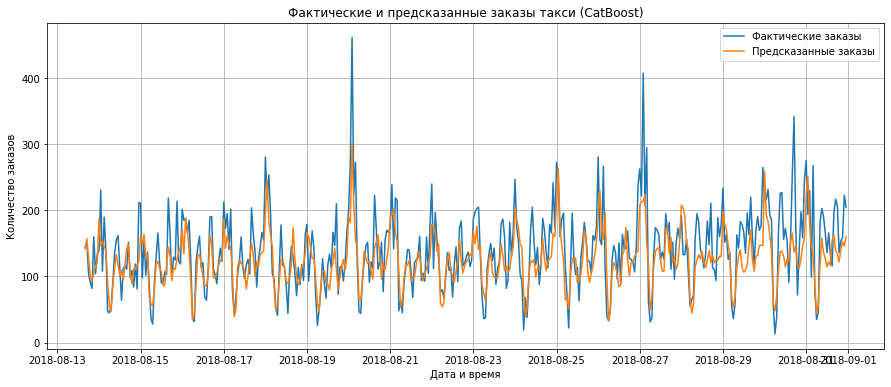

In [18]:
# Оценка лучшей модели на тестовой выборке
if best_model == 'Линейная регрессия':
    y_pred_best = model_lr.predict(X_test_scaled)
elif best_model == 'Случайный лес':
    y_pred_best = grid_rf.predict(X_test_scaled)
elif best_model == 'LightGBM':
    y_pred_best = grid_lgbm.predict(X_test_scaled)
elif best_model == 'CatBoost':
    y_pred_best = grid_cb.predict(X_test_scaled)
elif best_model == 'Gradient Boosting':
    y_pred_best = grid_gbr.predict(X_test_scaled)
elif best_model == 'SVR':
    y_pred_best = grid_svr.predict(X_test_scaled)
elif best_model == 'KNN':
    y_pred_best = grid_knn.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f'RMSE лучшей модели ({best_model}) на тестовой выборке: {rmse_test}')

# Визуализация предсказаний лучшей модели
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Фактические заказы')
plt.plot(test.index, y_pred_best, label='Предсказанные заказы')
plt.title(f'Фактические и предсказанные заказы такси ({best_model})')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid(True)
plt.show()

Вывод:

- По результатам RMSE выбрана модель CatBoost с наименьшим показателем 26.29 при кросс-валидации на тренировочной выборке и 41.41 на тестовой, что удовлетворяет условию "значение RMSE на тестовой выборке не больше 48".
